In [1]:
import pandas as pd
import numpy as np  
from numba import jit, cuda

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
molecule_entities = pd.read_csv("./fdb_molecules_entities.csv")
entities = pd.read_csv("./fdb_entities.csv")
molecules = pd.read_csv("./fdb_molecules.csv") 
recipe_ingredient = pd.read_csv("./Recipe_correct_ndb.csv")
recipe_region = pd.read_csv("./Recipe_small.csv")  

/home/ajay/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
molecule_entities

,id,fdb_molecules_id,fdb_entities_id
0,40,4,42
1,279,49,2
2,377,49,9
3,610,49,63
4,761,49,79
...,...,...,...
60258,16869,92043553,159
60259,13639,92043681,60
60260,19452,92043681,89
60261,13637,118855872,60


In [5]:
entities

,entity_id,category,category_readable,entity_alias,entity_alias_basket,entity_alias_readable,entity_alias_synonyms,entity_alias_url,natural_source_name,natural_source_url
0,0,animalproduct,Animal Product,egg,"egg, egg-boiled, egg-cooked, egg-scrambled",Egg,Egg,https://en.wikipedia.org/wiki/Egg_as_food,Chicken,https://en.wikipedia.org/wiki/Chicken
1,1,bakery,Bakery,bakery,bakery-products,Bakery Products,Bakery Products,https://en.wikipedia.org/wiki/Bakery,Poacceae,https://en.wikipedia.org/wiki/Poaceae
2,2,bakery,Bakery,bread,"bread, bread-preferment",Bread,Bread,https://en.wikipedia.org/wiki/Bread,Poacceae,https://en.wikipedia.org/wiki/Poaceae
3,3,bakery,Bakery,bread-rye,bread-rye,Rye Bread,Rye Bread,https://en.wikipedia.org/wiki/Rye_bread,Rye,https://en.wikipedia.org/wiki/Rye
4,4,bakery,Bakery,bread-wheaten,bread-wheaten,Wheaten Bread,"Soda scones, Soda farls",https://en.wikipedia.org/wiki/Soda_bread,Wheat,https://en.wikipedia.org/wiki/Wheat
...,...,...,...,...,...,...,...,...,...,...
931,970,fruit-berry,Berry,NaN,NaN,Saskatoon berry,"Saskatoon, Pacific serviceberry, Western serv...",https://en.wikipedia.org/wiki/Amelanchier_alni...,Amelanchier,https://en.wikipedia.org/wiki/Amelanchier
932,971,fruit-berry,Berry,NaN,NaN,Nanking cherry,"Korean cherry, Manchu cherry, Downy cherry, Sh...",https://en.wikipedia.org/wiki/Prunus_tomentosa,Prunus cerasus,https://en.wikipedia.org/wiki/Prunus_cerasus
933,972,fruit,Fruit,NaN,NaN,Japanese pumpkin,"Japanese pumpkin, Kabocha",https://en.wikipedia.org/wiki/Kabocha,Winter squash,https://en.wikipedia.org/wiki/Winter_squash
934,977,meat,Meat,NaN,NaN,Guinea hen,"Pet speckled hen, original fowl, Guinea fowl",https://en.wikipedia.org/wiki/Guinea_hen,Galliformes,https://en.wikipedia.org/wiki/Galliformes


In [6]:
molecules

,pubchem_id,iupac_name,common_name,smile,molecular_weight,hbd_count,hba_count,num_rotatablebonds,complexity,topological_polor_surfacearea,...,bitter,supersweetdb_id,bitterdb_id,fooddb_id,flavornet_id,fenoroli_and_os,natural,unknown_natural,synthetic,flavor_profile
0,4,1-aminopropan-2-ol,1-Aminopropan-2-ol,CC(CN)O,75.111,2,2,1,22.9,46.2,...,0,NaN,NaN,FDB008936,0,1,1,0,0,fishy
1,40,"6-(hydroxymethyl)oxane-2,4,5-triol",2-Deoxyhexopyranose,C1C(C(C(OC1O)CO)O)O,164.157,4,5,1,128.0,90.2,...,0,9189.0,NaN,NaN,0,0,0,0,0,sweet
2,47,3-methyl-2-oxopentanoic acid,3-Methyl-2-oxovaleric acid,CCC(C)C(=O)C(=O)O,130.143,1,3,3,128.0,54.4,...,0,NaN,NaN,NaN,0,1,0,0,0,NaN
3,49,3-methyl-2-oxobutanoic acid,3-Methyl-2-oxobutanoic acid,CC(C)C(=O)C(=O)O,116.116,1,3,2,115.0,54.4,...,0,NaN,NaN,FDB012250,0,1,1,0,0,fruity
4,51,2-oxopentanedioic acid,2-ketoglutaric acid,C(CC(=O)O)C(=O)C(=O)O,146.098,2,5,4,171.0,91.7,...,0,NaN,NaN,FDB003361,0,1,0,0,0,odorless
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,121460164,NaN,SCHEMBL17898401,CC12CCCC(C1CCC34C2CCC(C3)(C(=C)C4)OC5C(C(C(C(O...,1289.331,20,32,19,2400.0,523.0,...,0,22520.0,NaN,NaN,0,0,0,0,1,sweet-like
25591,121461316,"(2S,4S,5S)-2-(2,3-dihydroxypropoxy)-6-(hydroxy...",SCHEMBL17899769,C(C1C(C(C(C(O1)OCC(CO)O)O)O)O)O,254.235,6,8,5,225.0,140.0,...,0,22203.0,NaN,NaN,0,0,0,0,1,sweet-like
25592,121463299,NaN,SCHEMBL17901912,CC12CCCC(C1CCC34C2CCC(C3)(C(=C)C4)OC5C(C(C(C(O...,1289.331,20,32,19,2400.0,523.0,...,0,22521.0,NaN,NaN,0,0,0,0,1,sweet-like
25593,121484514,"(3S,4R,5S)-2-(6-aminopurin-9-yl)-5-(hydroxymet...",SCHEMBL17926245,C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O,267.245,4,8,2,335.0,140.0,...,0,33819.0,NaN,NaN,0,0,0,0,1,sweet-like


In [7]:
data = pd.merge(molecule_entities,molecules,left_on='fdb_molecules_id',right_on='pubchem_id')
data = pd.merge(data,entities,left_on='fdb_entities_id',right_on='entity_id')
data

,id,fdb_molecules_id,fdb_entities_id,pubchem_id,iupac_name,common_name,smile,molecular_weight,hbd_count,hba_count,...,entity_id,category,category_readable,entity_alias,entity_alias_basket,entity_alias_readable,entity_alias_synonyms,entity_alias_url,natural_source_name,natural_source_url
0,40,4,42,4,1-aminopropan-2-ol,1-Aminopropan-2-ol,CC(CN)O,75.111,2,2,...,42,beverage-alcoholic,Beverage Alcoholic,wine-sherry,"wine, wine-sherry",Sherry,Sherry,https://en.wikipedia.org/wiki/Sherry,Grape,https://en.wikipedia.org/wiki/Vitis_vinifera
1,24,72,42,72,"3,4-dihydroxybenzoic acid","3,4-Dihydroxybenzoic Acid",C1=CC(=C(C=C1C(=O)O)O)O,154.121,3,4,...,42,beverage-alcoholic,Beverage Alcoholic,wine-sherry,"wine, wine-sherry",Sherry,Sherry,https://en.wikipedia.org/wiki/Sherry,Grape,https://en.wikipedia.org/wiki/Vitis_vinifera
2,166,126,42,126,4-hydroxybenzaldehyde,4-hydroxybenzaldehyde,C1=CC(=CC=C1C=O)O,122.123,1,2,...,42,beverage-alcoholic,Beverage Alcoholic,wine-sherry,"wine, wine-sherry",Sherry,Sherry,https://en.wikipedia.org/wiki/Sherry,Grape,https://en.wikipedia.org/wiki/Vitis_vinifera
3,131,135,42,135,4-hydroxybenzoic acid,4-Hydroxybenzoic Acid,C1=CC(=CC=C1C(=O)O)O,138.122,2,3,...,42,beverage-alcoholic,Beverage Alcoholic,wine-sherry,"wine, wine-sherry",Sherry,Sherry,https://en.wikipedia.org/wiki/Sherry,Grape,https://en.wikipedia.org/wiki/Vitis_vinifera
4,125,179,42,179,3-hydroxybutan-2-one,acetoin,CC(C(=O)C)O,88.106,1,2,...,42,beverage-alcoholic,Beverage Alcoholic,wine-sherry,"wine, wine-sherry",Sherry,Sherry,https://en.wikipedia.org/wiki/Sherry,Grape,https://en.wikipedia.org/wiki/Vitis_vinifera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60258,39227,1201521,101,1201521,"(1R,4S)-2,2,4-trimethylbicyclo[2.2.1]heptan-3-one",D-Fenchone,CC1(C2CCC(C2)(C1=O)C)C,152.237,0,1,...,101,essentialoil,Essential Oil,cedar,cedar-leaf-oil,Cedar,Cedar,https://en.wikipedia.org/wiki/Cedrus,Cedrus,https://en.wikipedia.org/wiki/Cedrus
60259,39228,1550890,321,1550890,[(E)-3-phenylprop-2-enyl] (E)-3-phenylprop-2-e...,Cinnamyl cinnamate,C1=CC=C(C=C1)C=CCOC(=O)C=CC2=CC=CC=C2,264.324,0,2,...,321,plantderivative,Plant Derivative,storax,storax,Storax,"Styrax, Storax, Storax balsam",https://en.wikipedia.org/wiki/Storax_balsam,Liquidambar Orientalis,https://en.wikipedia.org/wiki/Liquidambar_orie...
60260,39229,3591866,298,3591866,1-oxacycloheptadec-7-en-2-one,Oxacycloheptadec-7-en-2-one,C1CCCCC=CCCCCC(=O)OCCCC1,252.398,0,2,...,298,nutseed-seed,Seed,muskmallow,muskmallow,Muskmallow,"Abelmosk, Ambrette seeds, Annual hibiscus, Bam...",https://en.wikipedia.org/wiki/Abelmoschus_mosc...,Abelmoschus,https://en.wikipedia.org/wiki/Abelmoschus
60261,39329,5311110,163,5311110,"(2R,3R,4R)-2,3,4,5-tetrahydroxypentanal",50-69-1,C(C(C(C(C=O)O)O)O)O,150.130,4,5,...,163,fruit,Fruit,apple-sauce,apple-sauce,Apple Sauce,Apple Sauce,https://en.wikipedia.org/wiki/Apple_sauce,Malus,https://en.wikipedia.org/wiki/Malus


In [8]:
def fun(string):
    print(string)
    s_arr = string.split("@")
    arr = []
    for s in s_arr:
        arr.append(s.strip())
    print(arr)
fun(data.iloc[0].functional_groups)

hydroxy compound@alcohol@secondary alcohol@1,2-aminoalcohol@amine@primary amine@primary aliphatic amine (alkylamine)
['hydroxy compound', 'alcohol', 'secondary alcohol', '1,2-aminoalcohol', 'amine', 'primary amine', 'primary aliphatic amine (alkylamine)']


In [9]:
entities_set = set(data["fdb_entities_id"])      # to find the unique ingredients 
print(len(entities_set))
d = {}
for ingredient in entities_set:
    d[ingredient] = []
#d        # key: entity, value: molecules of the given entity

936


In [10]:

def add_ingredient(d, entity_id, molecules):
    
    s_arr = str(molecules).split("@")
    molecules_arr = []
    for s in s_arr:
        molecules_arr.append(s.strip())
    
    entity_molecule_arr = d[entity_id]
    for molecule in molecules_arr:
        if molecule not in entity_molecule_arr:
            entity_molecule_arr.append(molecule)
        else:
            a = 1
#             print("repeation in entity")

            
for i in range(len(data)):
    row = data.iloc[i]
    entity_id = row["fdb_entities_id"]
    molecules = row.functional_groups
#     print(entity_id)
    add_ingredient(d, entity_id, molecules)

In [11]:
d

{0: ['cation',
  'anion',
  'quaternary ammonium salt',
  'carboxylic acid derivative',
  'carboxylic acid salt',
  'hydroxy compound',
  'phenol or hydroxyhetarene',
  'aromatic compound',
  'carboxylic acid',
  'nan',
  'carbonyl compound',
  'aldehyde',
  'alcohol',
  'secondary alcohol',
  'alpha-hydroxyacid',
  'heterocyclic compound',
  'thiol (sulfanyl compound)',
  'alkylthiol',
  'primary alcohol',
  'amine',
  'primary amine',
  'primary aliphatic amine (alkylamine)',
  'alpha-aminoacid',
  'thioether',
  'primary aromatic amine',
  'guanidine',
  'alkene',
  'ketone',
  'carboxylic acid ester',
  'disulfide',
  'sulfenic acid derivative',
  '1,2-diol'],
 1: ['aromatic compound', 'heterocyclic compound'],
 2: ['carbonyl compound',
  'ketone',
  'carboxylic acid derivative',
  'carboxylic acid',
  'hydroxy compound',
  'phenol or hydroxyhetarene',
  '1,2-diphenol',
  'aromatic compound',
  'aldehyde',
  'alcohol',
  'primary alcohol',
  'cation',
  'anion',
  'quaternary ammon

In [12]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def common_molecules(molecule_arr_1, molecule_arr_2):
    common_molecules_arr = intersection(molecule_arr_1, molecule_arr_2)
    return common_molecules_arr

final_arr = []
for entity_1 in d.keys():
    for entity_2 in d.keys():
        if(entity_1 != entity_2):
            common_molecules_arr = common_molecules(d[entity_1], d[entity_2])
            arr = [entity_1, entity_2, common_molecules_arr, len(common_molecules_arr)]
            final_arr.append(arr)


In [13]:
df = pd.DataFrame(final_arr, columns =['entity_1', 'entity_2', 'common_molecules_arr', 'count'])
df

,entity_1,entity_2,common_molecules_arr,count
0,0,1,"[aromatic compound, heterocyclic compound]",2
1,0,2,"[cation, anion, quaternary ammonium salt, carb...",29
2,0,3,"[cation, anion, carboxylic acid derivative, hy...",21
3,0,4,"[carboxylic acid derivative, hydroxy compound,...",16
4,0,5,"[carboxylic acid derivative, hydroxy compound,...",16
...,...,...,...,...
875155,978,969,"[hydroxy compound, phenol or hydroxyhetarene, ...",37
875156,978,970,"[hydroxy compound, phenol or hydroxyhetarene, ...",36
875157,978,971,"[hydroxy compound, phenol or hydroxyhetarene, ...",36
875158,978,972,"[hydroxy compound, phenol or hydroxyhetarene, ...",37


In [14]:
len(d)*len(d) - len(d)

875160

In [15]:
data_entity_name = entities[["entity_id","entity_alias_readable"]]
d_entity_name = {}
for i in range(len(data_entity_name)):
    d_entity_name[data_entity_name.iloc[i]["entity_id"]] = data_entity_name.iloc[i]["entity_alias_readable"] 
    
d_entity_name

{0: 'Egg',
 1: 'Bakery Products',
 2: 'Bread',
 3: 'Rye Bread',
 4: 'Wheaten Bread',
 5: 'White Bread',
 6: 'Wholewheat Bread',
 7: 'Wort',
 8: 'Arrack',
 9: 'Beer',
 10: 'Bantu Beer',
 11: 'Brandy',
 12: 'Anise Brandy',
 13: 'Apple Brandy',
 14: 'Armagnac Brandy',
 15: 'Blackberry Brandy',
 16: 'Cherry Brandy',
 17: 'Cognac Brandy',
 18: 'Papaya Brandy',
 19: 'Pear Brandy',
 20: 'Plum Brandy',
 21: 'Raspberry Brandy',
 22: 'Weinbrand Brandy',
 23: 'Gin',
 24: 'Rum',
 25: 'Whisky',
 26: 'Bourbon Whisky',
 27: 'Canadian Whisky',
 28: 'Finnish Whisky',
 29: 'Japanese Whisky',
 30: 'Malt Whisky',
 31: 'Scotch Whisky',
 32: 'Wine',
 33: 'Bilberry Wine',
 34: 'Botrytized Wine',
 35: 'Champagne',
 36: 'Cider',
 37: 'Plum Wine',
 38: 'Port Wine',
 39: 'Red Wine',
 40: 'Rose Wine',
 41: 'Sake',
 42: 'Sherry',
 43: 'Sparkling Wine',
 44: 'Strawberry Wine',
 45: 'White Wine',
 46: 'Coffee',
 47: 'Mate',
 48: 'Black Tea',
 49: 'Green Tea',
 50: 'Roibos Tea',
 51: 'Barley',
 52: 'Crispbread',
 53:

In [16]:
def addName(entity):
    global d_entity_name
    return d_entity_name[entity]

df["entity_1_name"] = df["entity_1"].apply(addName)
df["entity_2_name"] = df["entity_2"].apply(addName)

In [17]:
final_dataset = df[["entity_1", "entity_1_name", "entity_2", "entity_2_name", "count","common_molecules_arr"]]
final_dataset

,entity_1,entity_1_name,entity_2,entity_2_name,count,common_molecules_arr
0,0,Egg,1,Bakery Products,2,"[aromatic compound, heterocyclic compound]"
1,0,Egg,2,Bread,29,"[cation, anion, quaternary ammonium salt, carb..."
2,0,Egg,3,Rye Bread,21,"[cation, anion, carboxylic acid derivative, hy..."
3,0,Egg,4,Wheaten Bread,16,"[carboxylic acid derivative, hydroxy compound,..."
4,0,Egg,5,White Bread,16,"[carboxylic acid derivative, hydroxy compound,..."
...,...,...,...,...,...,...
875155,978,Cucurbita,969,Yellow zucchini,37,"[hydroxy compound, phenol or hydroxyhetarene, ..."
875156,978,Cucurbita,970,Saskatoon berry,36,"[hydroxy compound, phenol or hydroxyhetarene, ..."
875157,978,Cucurbita,971,Nanking cherry,36,"[hydroxy compound, phenol or hydroxyhetarene, ..."
875158,978,Cucurbita,972,Japanese pumpkin,37,"[hydroxy compound, phenol or hydroxyhetarene, ..."


In [18]:
# final_dataset.to_csv("Final Dataset.csv")

In [19]:
entity_name=df['entity_2_name']
entity_count=df['count']
entity_count.describe()

count    875160.000000
mean         17.563143
std           9.867008
min           0.000000
25%          12.000000
50%          15.000000
75%          20.000000
max          48.000000
Name: count, dtype: float64

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

<AxesSubplot:>

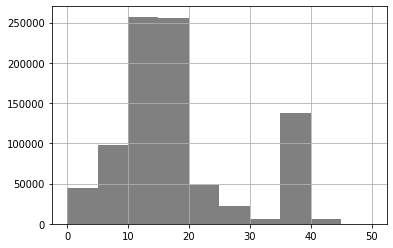

In [21]:

entity_count.hist(bins = 10, range=[0, 50], facecolor='gray')

In [22]:
# data_bridging=[]
# data_pairing=[]
# for index,row in df.iterrows():
#   if row['count']>35 and row['count']<40:
#     data_pairing.append(row)
#   if row['count']>10 and row['count']<20:
#     data_bridging.append(row)

In [23]:
# print(len(df),len(data_pairing),len(data_bridging))
# df_pairing=pd.DataFrame(data_pairing,columns=list(df))
# df_bridging=pd.DataFrame(data_bridging,columns=list(df))

In [24]:
# df_pairing
# df_bridging

In [25]:
# # Food Pairing
# entity_input=input()
# temp_data=[]
# for index,row in df_pairing.iterrows():
#   if row['entity_1_name']==entity_input:
#     temp_data.append(row)
# df_temp=pd.DataFrame(temp_data,columns=list(df))
# sorted_data=df_temp.sort_values(by = 'count',ascending=False)
# sorted_data.head(10)

In [26]:
# # Food Bridging 
# entity_input=input()
# temp_data=[]
# for index,row in df_bridging.iterrows():
#   if row['entity_1_name']==entity_input:
#     temp_data.append(row)
# df_temp=pd.DataFrame(temp_data,columns=list(df))
# sorted_data=df_temp.sort_values(by = 'count',ascending=False)
# sorted_data.head(10)

In [27]:
recipe_data = pd.merge(recipe_ingredient,recipe_region,left_on='recipe_no',right_on='Recipe_id')

In [28]:
recipe_data

,recipe_no,ingredient_Phrase,ingredient,state,quantity,unit,temp,df,size,ing_id,...,Energy (kcal),Protein (g),Total lipid (fat) (g),Utensils,Processes,vegan,pescetarian,ovo_vegetarian,lacto_vegetarian,ovo_lacto_vegetarian
0,2610,3 cups water,water,NaN,3,cups,NaN,NaN,NaN,3,...,805.6975,49.5540,5.6564,NaN,place||heat||cook||remove||cool||blend||smooth...,0.0,0.0,0.0,0.0,0.0
1,2610,1 cup red lentils,red lentil,NaN,1,cup,NaN,NaN,NaN,452,...,805.6975,49.5540,5.6564,NaN,place||heat||cook||remove||cool||blend||smooth...,0.0,0.0,0.0,0.0,0.0
2,2610,"1 roma tomato , quartered",rom tomato,quartered,1,NaN,NaN,NaN,NaN,180,...,805.6975,49.5540,5.6564,NaN,place||heat||cook||remove||cool||blend||smooth...,0.0,0.0,0.0,0.0,0.0
3,2610,"1 carrot , quartered",carrot,quartered,1,NaN,NaN,NaN,NaN,21,...,805.6975,49.5540,5.6564,NaN,place||heat||cook||remove||cool||blend||smooth...,0.0,0.0,0.0,0.0,0.0
4,2610,"1 small onion , quartered",onion,quartered,1,NaN,NaN,NaN,small,1,...,805.6975,49.5540,5.6564,NaN,place||heat||cook||remove||cool||blend||smooth...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191734,149191,2 1/2 ounces dates,date,NaN,2 1/2,1/2,NaN,NaN,NaN,281,...,3975.5505,72.5065,133.0444,bowl||processor||pan,cover||drain||add||puree||press||chill||cut,0.0,0.0,0.0,0.0,0.0
1191735,149191,9 1/2 9 1/2 ounces three-legume butter ( Recip...,butter,almond,9 1/2,ounces,NaN,NaN,NaN,2,...,3975.5505,72.5065,133.0444,bowl||processor||pan,cover||drain||add||puree||press||chill||cut,0.0,0.0,0.0,0.0,0.0
1191736,149191,1 teaspoon vanilla,vanilla,NaN,1,teaspoon,NaN,NaN,NaN,77,...,3975.5505,72.5065,133.0444,bowl||processor||pan,cover||drain||add||puree||press||chill||cut,0.0,0.0,0.0,0.0,0.0
1191737,149191,1/2 teaspoon cinnamon,cinnamon,NaN,1/2,teaspoon,NaN,NaN,NaN,15,...,3975.5505,72.5065,133.0444,bowl||processor||pan,cover||drain||add||puree||press||chill||cut,0.0,0.0,0.0,0.0,0.0


In [29]:
recipe_data_dict={}
recipe_data_array=[]
for index,row in recipe_data.iterrows():
    if recipe_data_dict.get(int(row['recipe_no']))==None:recipe_data_dict[int(row['recipe_no'])]=[]
    recipe_data_dict[int(row['recipe_no'])].append(row['ingredient'])

In [30]:
recipe_region_dict={}
for index,row in recipe_data.iterrows():
  recipe_region_dict[int(row['Recipe_id'])]=row['Region']

In [31]:
# recipe_name_dict={}
# for index,row in entities.iterrows():
#   recipe_name_dict[int(row['entity_id'])]=row['entity_alias_readable']

for key in recipe_data_dict.keys():
  recipe_data_array.append([key,recipe_data_dict[key],recipe_region_dict[key]])
recipe_data_array

recipe_data_df=pd.DataFrame(recipe_data_array,columns=['recipeId','ingredient','Region'])
recipe_data_df

,recipeId,ingredient,Region
0,2610,"[water, red lentil, rom tomato, carrot, onion,...",Middle Eastern
1,2611,"[vegetable oil, onion, tomato paste, garlic, c...",Middle Eastern
2,2612,"[olive oil, onion, lamb shoulder, salt black p...",Middle Eastern
3,2613,"[onion, olive oil, garbanzo bean, cream, cornm...",Middle Eastern
4,2614,"[hazelnut, sesame seed, coriander seed, cumin ...",Middle Eastern
...,...,...,...
118107,149187,"[jerusalem artichoke, jalapeno pepper, red pep...",Canadian
118108,149188,"[asian pear, water, ginger, cardamom seed]",Canadian
118109,149189,"[olive oil, onion, potato, vegetable stock, sa...",Canadian
118110,149190,"[margarine, sugar, vanilla, baking powder, sal...",Canadian


In [32]:
recipe_data_pairing_dict={}
for index,row in final_dataset.iterrows():
  name=str(row['entity_1_name']).lower()+'|'+str(row['entity_2_name']).lower()
  recipe_data_pairing_dict[name]=row['count']
# recipe_data_pairing_dict

In [33]:

recipe_pairing_data=[]
for index,row in recipe_data_df.iterrows():
  count=0
  ingredient_count=0
  for x in row['ingredient']:
    for y in row['ingredient']:
      if x!=y:
        name=str(x).lower()+'|'+str(y).lower()
        # if not recipe_data_pairing_dict.get(name):print(name)
        if recipe_data_pairing_dict.get(name):
          count+=recipe_data_pairing_dict.get(name)
          ingredient_count+=1
  # if ingredient_count!=0:
  avg_food_pairing=count/len(row['ingredient'])
  recipe_pairing_data.append([row['recipeId'],row['Region'],avg_food_pairing,len(row['ingredient'])])
  # avg_food_pairing=count/ingredient_count
  # recipe_pairing_data.append([row['recipeId'],row['Region'],avg_food_pairing,ingredient_count])
recipe_pairing_data

[[2610, 'Middle Eastern', 100.0, 11],
 [2611, 'Middle Eastern', 26.444444444444443, 9],
 [2612, 'Middle Eastern', 19.714285714285715, 7],
 [2613, 'Middle Eastern', 81.5, 12],
 [2614, 'Middle Eastern', 0.0, 6],
 [2615, 'Middle Eastern', 60.0, 9],
 [2616, 'Middle Eastern', 23.8, 10],
 [2617, 'Middle Eastern', 18.307692307692307, 13],
 [2618, 'Middle Eastern', 53.111111111111114, 9],
 [2619, 'Middle Eastern', 68.88888888888889, 18],
 [2620, 'Middle Eastern', 58.8, 5],
 [2621, 'Middle Eastern', 34.0, 7],
 [2622, 'Middle Eastern', 32.4, 5],
 [2623, 'Middle Eastern', 34.5, 8],
 [2624, 'Middle Eastern', 25.11111111111111, 9],
 [2625, 'Middle Eastern', 34.22222222222222, 9],
 [2626, 'Middle Eastern', 15.333333333333334, 6],
 [2627, 'Middle Eastern', 33.333333333333336, 6],
 [2628, 'Middle Eastern', 32.888888888888886, 9],
 [2629, 'Middle Eastern', 35.0, 10],
 [2630, 'Middle Eastern', 8.0, 4],
 [2631, 'Middle Eastern', 86.18181818181819, 11],
 [2632, 'Middle Eastern', 63.88235294117647, 17],
 [

In [34]:
recipe_pairing_data_df=pd.DataFrame(recipe_pairing_data,columns=['recipeId','Region','Food Pairing Value','Ingredient Count'])

region_pairing_dict={}
region_ingredient_dict={}
region_recipe_count={}
for index,row in recipe_pairing_data_df.iterrows():
  if region_pairing_dict.get(row['Region'])==None:region_pairing_dict[row['Region']]=[]
  if region_ingredient_dict.get(row['Region'])==None:region_ingredient_dict[row['Region']]=[]
  if region_recipe_count.get(row['Region'])==None:region_recipe_count[row['Region']]=0
  region_pairing_dict[row['Region']].append(row['Food Pairing Value'])
  region_ingredient_dict[row['Region']].append(row['Ingredient Count'])
  region_recipe_count[row['Region']]+=1


In [35]:

region_final=[]
for key in region_pairing_dict.keys():
  # region_pairing_dict
  region_final.append([key,sum(region_pairing_dict[key])/len(region_pairing_dict[key]),sum(region_ingredient_dict[key])/len(region_ingredient_dict[key]),len(region_pairing_dict[key])])

region_final=sorted(region_final,key=lambda x:x[1])

region_final

[['Korean', 25.74987162605853, 10.634730538922156, 668],
 ['Japanese', 29.048192493903564, 9.146496815286625, 2041],
 ['Thai', 29.81306834392134, 11.882059162504802, 2603],
 ['Mexican', 35.718967203017726, 10.04457055851616, 14449],
 ['Chinese and Mongolian', 36.54126934249979, 10.959748641304348, 5888],
 ['US', 38.594315384849715, 9.557940767243092, 5031],
 ['Australian', 41.55855259404053, 8.703487373303556, 5821],
 ['Southeast Asian', 42.0823226766926, 11.456701030927835, 1940],
 ['Spanish and Portuguese', 46.78928274236406, 9.986638537271448, 2844],
 ['Caribbean', 47.470993598641236, 10.320542507442937, 3023],
 ['Irish', 48.80624539409956, 8.88888888888889, 2529],
 ['UK', 49.4964831695362, 8.812727272727273, 4400],
 ['Central American', 49.61625901669187, 9.82857142857143, 455],
 ['Italian', 50.9411353193778, 10.272442084942085, 16576],
 ['South American', 53.327431496454366, 10.707555059938667, 7174],
 ['Canadian', 54.753285214024565, 9.321988356471115, 6699],
 ['French', 54.86097

<Figure size 432x288 with 0 Axes>

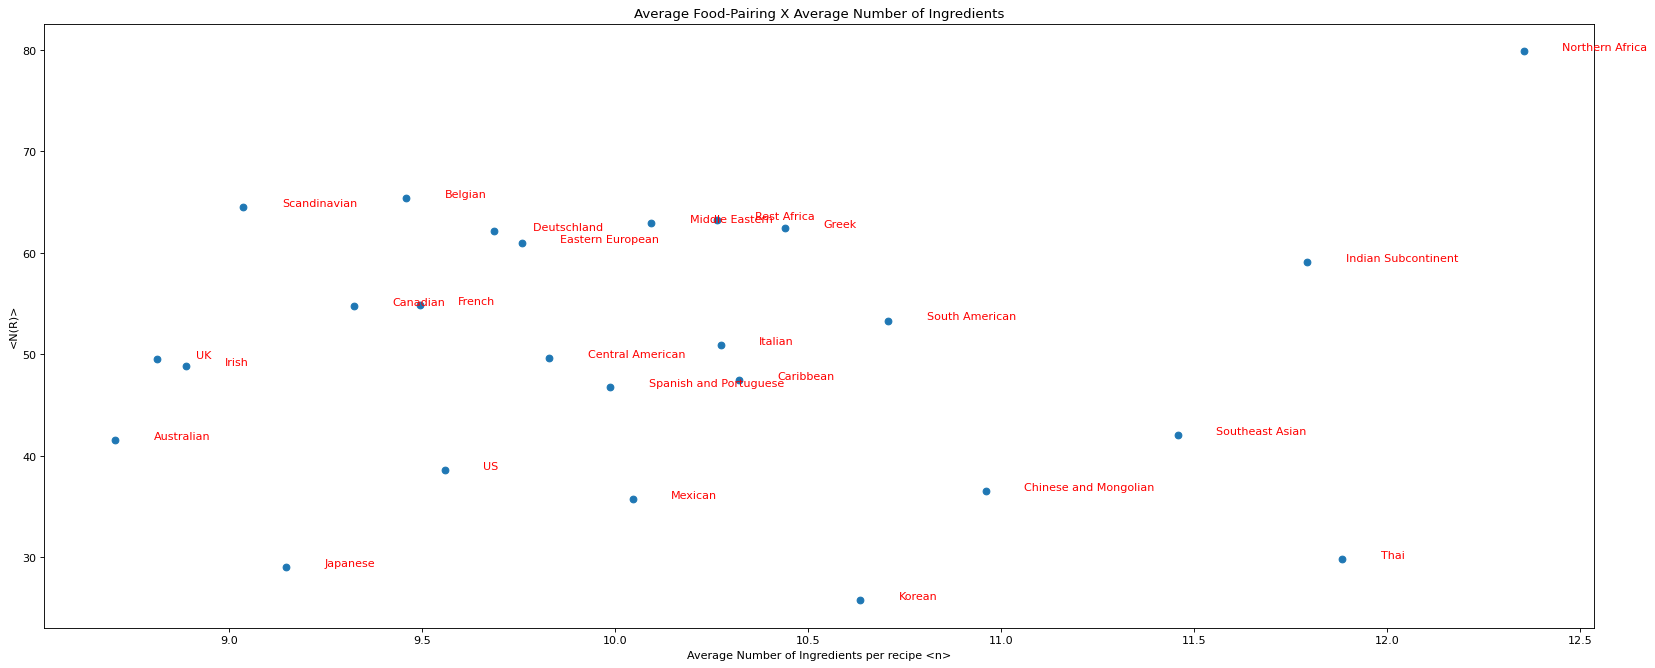

In [36]:
food_pairing_value=[]
region=[]
no_of_ingredient=[]
for d in region_final:
  no_of_ingredient.append(d[2])
  region.append(d[0])
  food_pairing_value.append(d[1])
plt.figure(0)
figure(figsize=(25, 10), dpi=80)
plt.xlabel('Average Number of Ingredients per recipe <n>')
plt.ylabel('<N(R)>')
plt.title('Average Food-Pairing X Average Number of Ingredients')
plt.scatter(no_of_ingredient,food_pairing_value)

for i in range(len(region_final)):
 plt.text(x=no_of_ingredient[i]+0.1,y=food_pairing_value[i]+0.1,
          s=region[i],
          fontdict=dict(color='red',size=10))

In [37]:
region_final

[['Korean', 25.74987162605853, 10.634730538922156, 668],
 ['Japanese', 29.048192493903564, 9.146496815286625, 2041],
 ['Thai', 29.81306834392134, 11.882059162504802, 2603],
 ['Mexican', 35.718967203017726, 10.04457055851616, 14449],
 ['Chinese and Mongolian', 36.54126934249979, 10.959748641304348, 5888],
 ['US', 38.594315384849715, 9.557940767243092, 5031],
 ['Australian', 41.55855259404053, 8.703487373303556, 5821],
 ['Southeast Asian', 42.0823226766926, 11.456701030927835, 1940],
 ['Spanish and Portuguese', 46.78928274236406, 9.986638537271448, 2844],
 ['Caribbean', 47.470993598641236, 10.320542507442937, 3023],
 ['Irish', 48.80624539409956, 8.88888888888889, 2529],
 ['UK', 49.4964831695362, 8.812727272727273, 4400],
 ['Central American', 49.61625901669187, 9.82857142857143, 455],
 ['Italian', 50.9411353193778, 10.272442084942085, 16576],
 ['South American', 53.327431496454366, 10.707555059938667, 7174],
 ['Canadian', 54.753285214024565, 9.321988356471115, 6699],
 ['French', 54.86097

<Figure size 432x288 with 0 Axes>

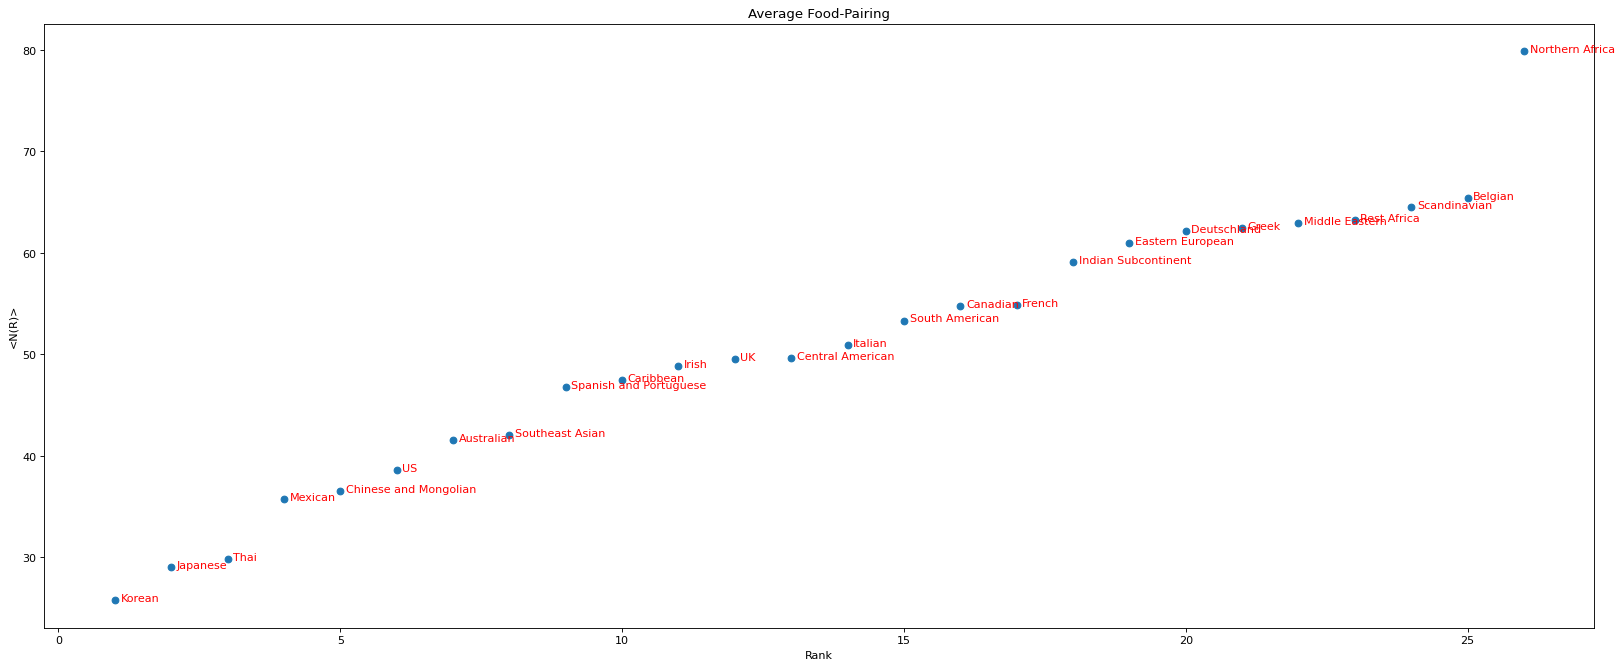

In [38]:
ranks=[i for i in range(1,len(region_final)+1)]
plt.figure(1)
figure(figsize=(25, 10), dpi=80)
plt.xlabel('Rank')
plt.ylabel('<N(R)>')
plt.title('Average Food-Pairing')
plt.scatter(ranks,food_pairing_value)

for i in range(len(region_final)):
 plt.text(x=ranks[i]+0.1,y=food_pairing_value[i]-0.1,
          s=region[i],
          fontdict=dict(color='red',size=10))

In [ ]:
import networkx as nx
from multiprocessing import Process

def bridging(number,df_input):
    recipe_bridging_data=[]
    recipe_bridging_dict={}
    iter_count=0
    for index,row in df_input.iterrows():
      print(index)

      #if iter_count>10000:break
      iter_count+=1

      G = nx.Graph()

      edge_list=row['ingredient']
      for v1 in edge_list:
          G.add_node(v1)
          for v2 in edge_list:
              name=str(v1)+'|'+str(v2)
              if v1!=v2 and recipe_data_pairing_dict.get(name):
                  G.add_edge(v1,v2, weight=recipe_data_pairing_dict.get(name))


      paths_dict={}
      total=0
      count=0

      for v1 in edge_list:
          for v2 in edge_list:
            name=str(v1)+'|'+str(v2)
            name2=str(v2)+'|'+str(v1)
            if v1!=v2 and nx.has_path(G,v1,v2) and paths_dict.get(name)==None and paths_dict.get(name2)==None:

              max=0
              for x in nx.all_simple_paths(G,source=v1,target=v2):

                if len(x)>2:
                  # print(v1,v2,x)
                  sum=0

                  for i in range(len(x)-1):
                    n=str(x[i])+'|'+str(x[i+1])
                    sum+=recipe_data_pairing_dict.get(n)

                  if sum>max:max=sum

              paths_dict[name]=max


              total+=max
              count+=1

      # print(paths_dict)
      avg=total/count if count!=0 else 0
      # print(paths)
      recipe_bridging_data.append([row['recipeId'],row['Region'],avg,len(row['ingredient'])])
    recipe_bridging_data_df=pd.DataFrame(recipe_bridging_data,columns=['recipeId','Region','Food Bridging Value','Ingredient Count'])
    recipe_bridging_data_df.to_csv('./bridging/bridging_{}.csv'.format(number),sep=',')
# recipe_bridging_data=bridging(recipe_data_df,recipe_data_pairing_dict)

p1 = Process(target=bridging, args=(1,recipe_data_df.iloc[0:100]))
p2 = Process(target=bridging, args=(2,recipe_data_df.iloc[100:200]))
p3 = Process(target=bridging, args=(3,recipe_data_df.iloc[200:300]))
p4 = Process(target=bridging, args=(4,recipe_data_df.iloc[300:400]))
p5 = Process(target=bridging, args=(5,recipe_data_df.iloc[400:500]))


p2.start()
p3.start()
p4.start()
p5.start()
p1.start()



p2.join()
p1.join()
p3.join()
p4.join()
p5.join()

100
200
201300

301400

302
401
3030402


403304
404

1
405
2305406


407306
3

408
307409

308410

411309

412
310
413
414
415
311416

417312

313418

4194314


4205

3154216


422316
7
423

424317
4258


4269

427
318
428
319429

430
431
432
433
434
435
436
437
438
10439

11
12
440
13
441
14442

15
16443

17
444
18
445
19446

20447

21448

449
22
23
24
25
26
27
28
450
451
29452

45330

454
455
456
31
32
33
34
35
36
37
38
45739

45840

41
42
43
44
45
46
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
101
202
203
204
205
206
207
208
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
35847

359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
48
49
50
51
52
53
54
5

In [ ]:
len(recipe_data_df)

gfjkyj

In [ ]:
recipe_bridging_data_df=pd.DataFrame(recipe_bridging_data,columns=['recipeId','Region','Food Bridging Value','Ingredient Count'])

region_bridging_dict={}
region_ingredient_dict_bridging={}
region_recipe_count_bridging={}
for index,row in recipe_bridging_data_df.iterrows():
  if region_bridging_dict.get(row['Region'])==None:region_bridging_dict[row['Region']]=[]
  if region_ingredient_dict_bridging.get(row['Region'])==None:region_ingredient_dict_bridging[row['Region']]=[]
  if region_recipe_count_bridging.get(row['Region'])==None:region_recipe_count_bridging[row['Region']]=0
  region_bridging_dict[row['Region']].append(row['Food Bridging Value'])
  region_ingredient_dict_bridging[row['Region']].append(row['Ingredient Count'])
  region_recipe_count_bridging[row['Region']]+=1


In [ ]:

region_final_bridging=[]
for key in region_bridging_dict.keys():
  # region_pairing_dict
  region_final.append([key,sum(region_bridging_dict[key])/len(region_bridging_dict[key]),sum(region_ingredient_dict_bridging[key])/len(region_ingredient_dict_bridging[key]),len(region_bridging_dict[key])])

region_final_bridging=sorted(region_final_bridging,key=lambda x:x[1])

region_final_bridging